In [1]:
!git clone https://github.com/EliseBcl/Defi_IA_2023.git

Cloning into 'Defi_IA_2023'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 122 (delta 54), reused 75 (delta 22), pack-reused 0
Receiving objects: 100% (122/122), 14.64 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log
import seaborn as sns
from sklearn.preprocessing import scale
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
#from factor_analyzer import FactorAnalyzer
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})


In [3]:
Matrix1 = pd.read_csv('/content/Defi_IA_2023/requests_1.csv',index_col=0)
Matrix2 = pd.read_csv('/content/Defi_IA_2023/requests_2.csv',index_col=0)
Matrix4 = pd.read_csv('/content/Defi_IA_2023/requests_4.csv',index_col=0)
Matrix5 = pd.read_csv('/content/Defi_IA_2023/requests_5.csv',index_col=0)

In [4]:
Matrix1 = Matrix1.assign(order_request=1)
Matrix2 = Matrix2.assign(order_request=2)
Matrix4 = Matrix4.assign(order_request=4)
Matrix5 = Matrix5.assign(order_request=5)

In [5]:
def assign_requests_order(copy_requests):
  requests = copy_requests.copy()

  #def DF requests order
  requests_order = pd.DataFrame(requests.index)
  requests_order.columns = ['order_request']
  requests_order.request_order = 0

  #modif order 
  for n in requests.name.unique():
    for d in requests[requests.name == n].date.unique():
      requests_order[(requests.name == n).values * (requests.date == d).values] = np.where(requests[requests.name == n].date.unique() == d)[0] + 1 
  return requests_order

In [6]:
for name_r in ['requests_6_part1', 'requests_6_part2', 'requests_8_part1', 'requests_8_part2', 'requests_8_part3']:
  r = pd.read_csv('/content/Defi_IA_2023/'+name_r+'.csv',index_col=0)
  b = r.copy()
  c = assign_requests_order(b)
  r = pd.read_csv('/content/Defi_IA_2023/'+name_r+'.csv',index_col=0)
  r = r.join(c)
  r.to_csv('/content/Defi_IA_2023/'+ name_r + '_order.csv')

In [7]:
#request 6
Matrix6_part1 = pd.read_csv('/content/Defi_IA_2023/'+'requests_6_part1'+'_order.csv',index_col=0)
# display(Matrix6_part1)
Matrix6_part2 = pd.read_csv('/content/Defi_IA_2023/'+'requests_6_part2'+'_order.csv',index_col=0)
# display(Matrix6_part2)
#requests 8
Matrix8_part1 = pd.read_csv('/content/Defi_IA_2023/requests_8_part1_order.csv',index_col=0)
Matrix8_part2 = pd.read_csv('/content/Defi_IA_2023/requests_8_part2_order.csv',index_col=0)
Matrix8_part3 = pd.read_csv('/content/Defi_IA_2023/requests_8_part3_order.csv',index_col=0)

In [8]:
data = pd.concat([Matrix1, Matrix2, Matrix4,Matrix5, Matrix6_part1, Matrix6_part2,Matrix8_part1, Matrix8_part2, Matrix8_part3])

In [9]:
data = data.drop(['name', 'avatar_id'], axis=1)

In [10]:
def to_categorical(data_test):
  # merge on hotel id
  hotels = pd.read_csv('/content/Defi_IA_2023/features_hotels.csv',index_col=0)
  hotels = hotels.drop(['city'], axis = 1)
  data_test = data_test.join(hotels, on = 'hotel_id')

  # to categorical
  
  data_test['hotel_id'] = pd.Categorical(data_test.hotel_id)
  data_test['city'] = pd.Categorical(data_test.city)
  data_test['language'] = pd.Categorical(data_test.language)
  data_test['mobile'] = pd.Categorical(data_test.mobile)
  data_test['group'] = pd.Categorical(data_test.group)
  data_test['brand'] = pd.Categorical(data_test.brand)
  data_test['parking'] = pd.Categorical(data_test.parking)
  data_test['pool'] = pd.Categorical(data_test.pool)
  data_test['children_policy'] = pd.Categorical(data_test.children_policy)
  
  return data_test

In [11]:
data = to_categorical(data)

In [13]:
def format_test(X):
  X_test = X.copy()

  hotels = pd.read_csv('/content/Defi_IA_2023/features_hotels.csv',index_col=0)
  hotels = hotels.drop(['city'], axis = 1)
  X_test = X_test.join(hotels, on = 'hotel_id')

  # order request
  X_test = X_test.assign(order_request=0)
  X_test['order_request'] = 1
  for avatar in np.unique(X_test['avatar_id']):
      X_test.loc[X_test['avatar_id'] == avatar, 'order_request'] = X_test['order_requests'].loc[X_test['avatar_id']== avatar] - min(X_test['order_requests'].loc[X_test['avatar_id']== avatar])+1
  X_test = X_test.drop(['order_requests'], axis = 1)

  return X_test

X_test = pd.read_csv('/content/Defi_IA_2023/test_set.csv',index_col=0)
data_test = format_test(X_test.copy())

# Explanatory analysis

In [14]:
data.duplicated().sum()

44684

In [15]:
data.drop_duplicates(keep = 'first', inplace=True)

In [16]:
data

,hotel_id,price,stock,city,date,language,mobile,order_request,group,brand,parking,pool,children_policy
0,663,149,84,paris,35,romanian,0,1,Chillton Worldwide,Tripletree,0,0,0
1,912,164,73,paris,35,romanian,0,1,Boss Western,J.Halliday Inn,0,0,0
2,640,152,70,paris,35,romanian,0,1,Boss Western,J.Halliday Inn,0,0,0
3,656,106,64,paris,35,romanian,0,1,Boss Western,Boss Western,1,0,0
4,792,82,76,paris,35,romanian,0,1,Independant,Independant,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38105,241,123,0,madrid,9,portuguese,0,8,Boss Western,J.Halliday Inn,1,0,0
38106,102,267,13,madrid,9,portuguese,0,8,Morriott International,Corlton,1,1,0
38107,2,90,0,madrid,9,portuguese,0,8,Independant,Independant,0,0,0
38108,108,94,2,madrid,9,portuguese,0,8,Independant,Independant,0,0,0


In [36]:
data.pool = data.pool.astype(object)
data.parking = data.parking.astype(object)
data.children_policy = data.children_policy.astype(object)
data.mobile = data.mobile.astype(object)
data.hotel_id =data.hotel_id.astype(object)
data.city =data.city.astype(object)
data.language =data.language.astype(object)
data.group =data.group.astype(object)
data.brand =data.brand.astype(object)
data.order_request =data.order_request.astype(object)


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453940 entries, 0 to 38109
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   hotel_id         453940 non-null  object
 1   price            453940 non-null  int64 
 2   stock            453940 non-null  int64 
 3   city             453940 non-null  object
 4   date             453940 non-null  int64 
 5   language         453940 non-null  object
 6   mobile           453940 non-null  object
 7   order_request    453940 non-null  object
 8   group            453940 non-null  object
 9   brand            453940 non-null  object
 10  parking          453940 non-null  object
 11  pool             453940 non-null  object
 12  children_policy  453940 non-null  object
dtypes: int64(3), object(10)
memory usage: 48.5+ MB


In [38]:
data.describe()

,price,stock,date
count,453940.000000,453940.000000,453940.000000
mean,154.844885,23.010125,15.797892
std,80.652921,32.974528,9.736662
min,40.000000,0.000000,0.000000
25%,93.000000,3.000000,8.000000
50%,137.000000,11.000000,14.000000
75%,192.000000,28.000000,21.000000
max,538.000000,221.000000,38.000000


In [39]:
cat_vars = [var for var in data.columns if data[var].dtypes == 'O'] # Object Variables
print("Total no.of categorical variables in the dataset: ", cat_vars)
continuous_features = [var for var in data.columns if data[var].dtypes!= 'O'] # Non-Object Variables
print("Total no.of numerical variables in the dataset: ", continuous_features)

Total no.of categorical variables in the dataset:  ['hotel_id', 'city', 'language', 'mobile', 'order_request', 'group', 'brand', 'parking', 'pool', 'children_policy']
Total no.of numerical variables in the dataset:  ['price', 'stock', 'date']


In [40]:
for var in cat_vars[1:]:
    print(var,'-->', len(data[var].unique()), "Categories : ", data[var].unique())

city --> 9 Categories :  ['paris' 'copenhagen' 'madrid' 'rome' 'sofia' 'vilnius' 'vienna'
 'amsterdam' 'valletta']
language --> 27 Categories :  ['romanian' 'swedish' 'maltese' 'belgian' 'luxembourgish' 'dutch' 'french'
 'finnish' 'austrian' 'slovakian' 'hungarian' 'bulgarian' 'danish' 'greek'
 'croatian' 'polish' 'german' 'spanish' 'estonian' 'lithuanian' 'cypriot'
 'latvian' 'irish' 'italian' 'slovene' 'czech' 'portuguese']
mobile --> 2 Categories :  [0 1]
order_request --> 10 Categories :  [1 2 4 5 3 6 7 8 9 10]
group --> 6 Categories :  ['Chillton Worldwide' 'Boss Western' 'Independant' 'Accar Hotels'
 'Morriott International' 'Yin Yang']
brand --> 16 Categories :  ['Tripletree' 'J.Halliday Inn' 'Boss Western' 'Independant' 'Ibas'
 'Quadrupletree' 'Safitel' 'Corlton' 'Royal Lotus' 'Navatel'
 'Chill Garden Inn' 'Morriot' 'Marcure' '8 Premium' 'CourtYord' 'Ardisson']
parking --> 2 Categories :  [0 1]
pool --> 2 Categories :  [0 1]
children_policy --> 3 Categories :  [0 1 2]


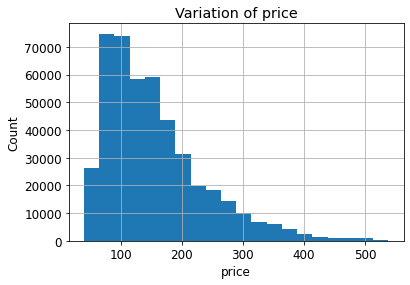

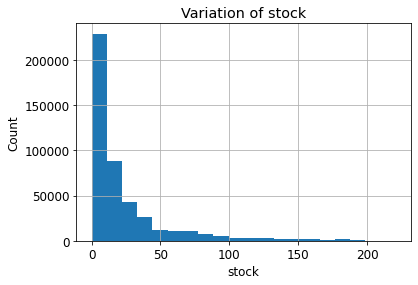

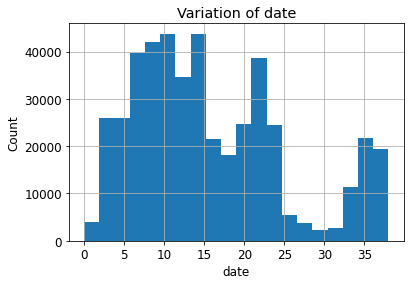

In [41]:
def analyze_cont_vars(df,var):
    
    new_df = df.copy()
    new_df[var].hist(bins=20)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title('Variation of '+ var)
    plt.show()
    
for var in continuous_features:
    analyze_cont_vars(data,var)

Transformations of Continuous Variables

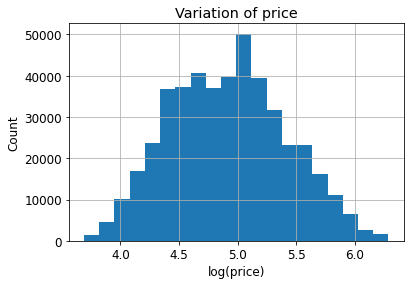

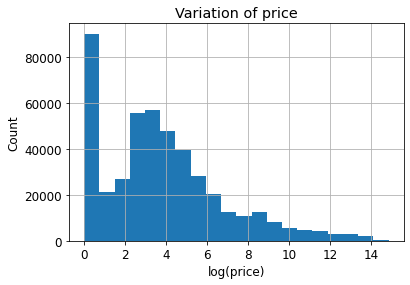

In [43]:
np.log(data.price + 0.001).hist(bins=20)
plt.xlabel('log(price)')
plt.ylabel('Count')
plt.title('Variation of price')
plt.show()
##########################################
np.sqrt(data.stock).hist(bins=20)
plt.xlabel('log(price)')
plt.ylabel('Count')
plt.title('Variation of price')
plt.show()

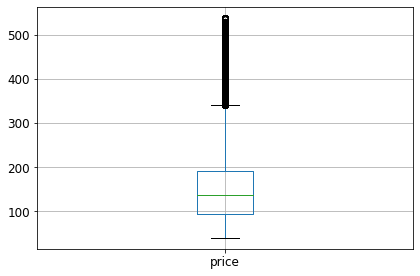

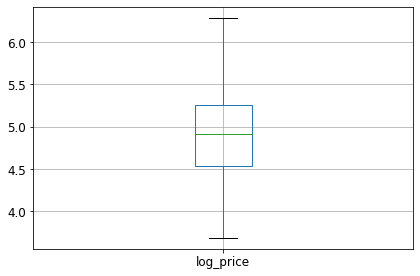

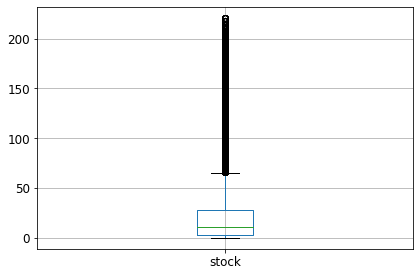

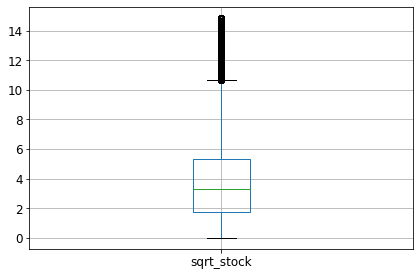

In [44]:
data.boxplot(column = 'price')
plt.tight_layout()
plt.show()

data_copy= data.copy()
data_copy['log_price'] = np.log(data.price + 0.001)
data_copy.boxplot(column = 'log_price')
plt.tight_layout()
plt.show()
################################
data.boxplot(column = 'stock')
plt.tight_layout()
plt.show()

data_copy['sqrt_stock'] = np.sqrt(data.stock)
data_copy.boxplot(column = 'sqrt_stock')
plt.tight_layout()
plt.show()

Multi-dimensional analysis

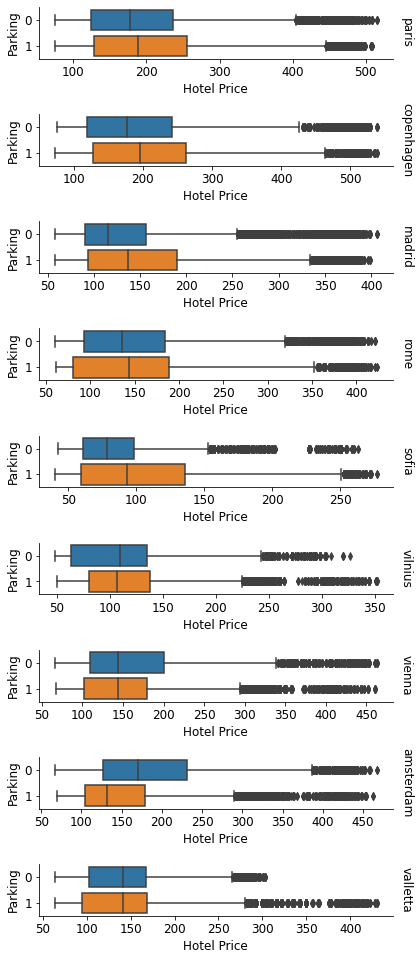

In [48]:
g = sns.catplot(
    data=data,
    x="price", y="parking", row="city", 
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Hotel Price", ylabel="Parking")
g.set_titles(row_template="{row_name}")

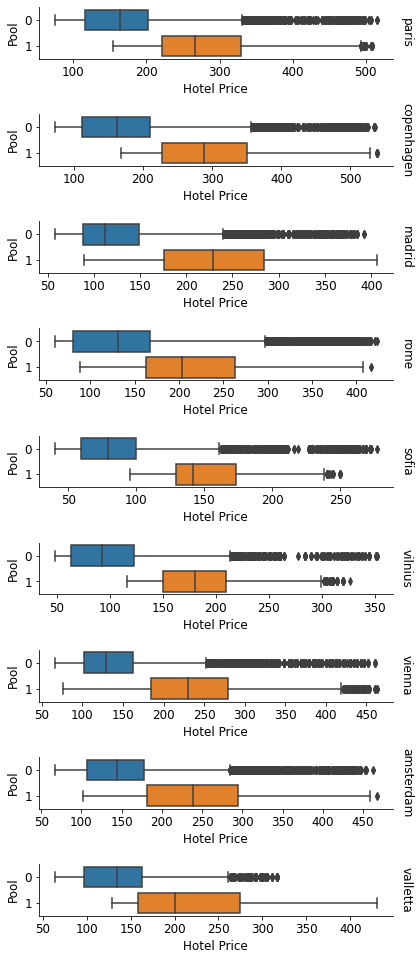

In [49]:
g = sns.catplot(
    data=data,
    x="price", y="pool", row="city",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Hotel Price", ylabel="Pool")
g.set_titles(row_template="{row_name}")

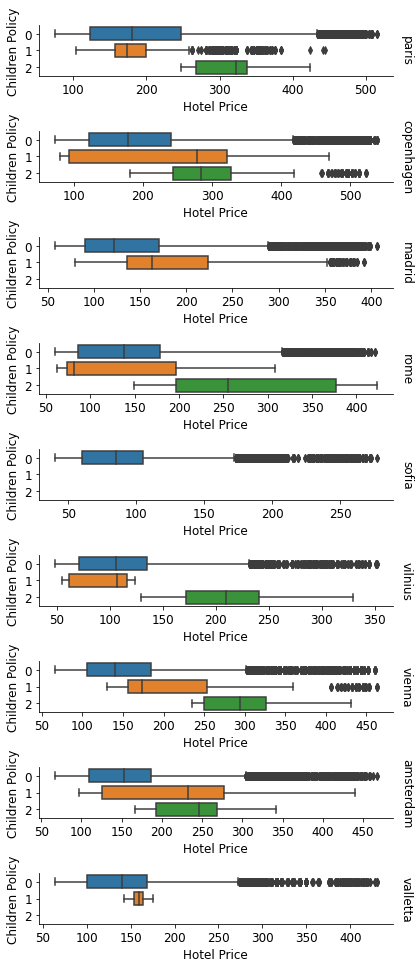

In [50]:
g = sns.catplot(
    data=data,
    x="price", y="children_policy", row="city",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Hotel Price", ylabel="Children Policy")
g.set_titles(row_template="{row_name}")

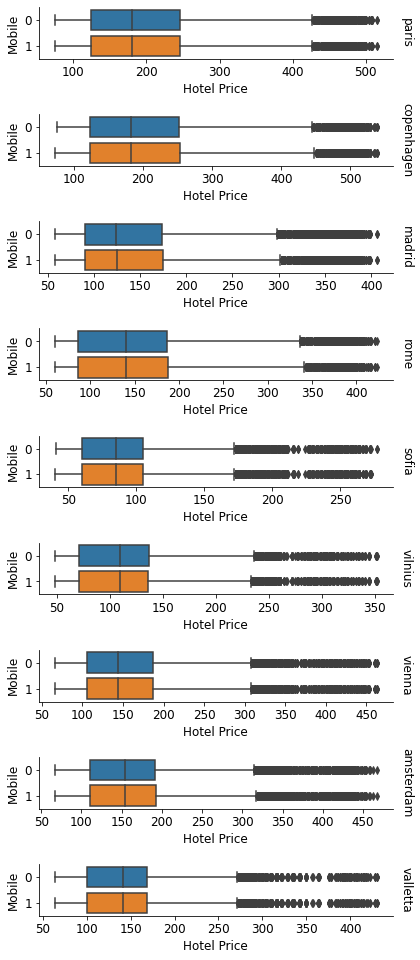

In [51]:
g = sns.catplot(
    data=data,
    x="price", y="mobile", row="city",
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Hotel Price", ylabel="Mobile")
g.set_titles(row_template="{row_name}")

In [52]:
correlation = data.corr()

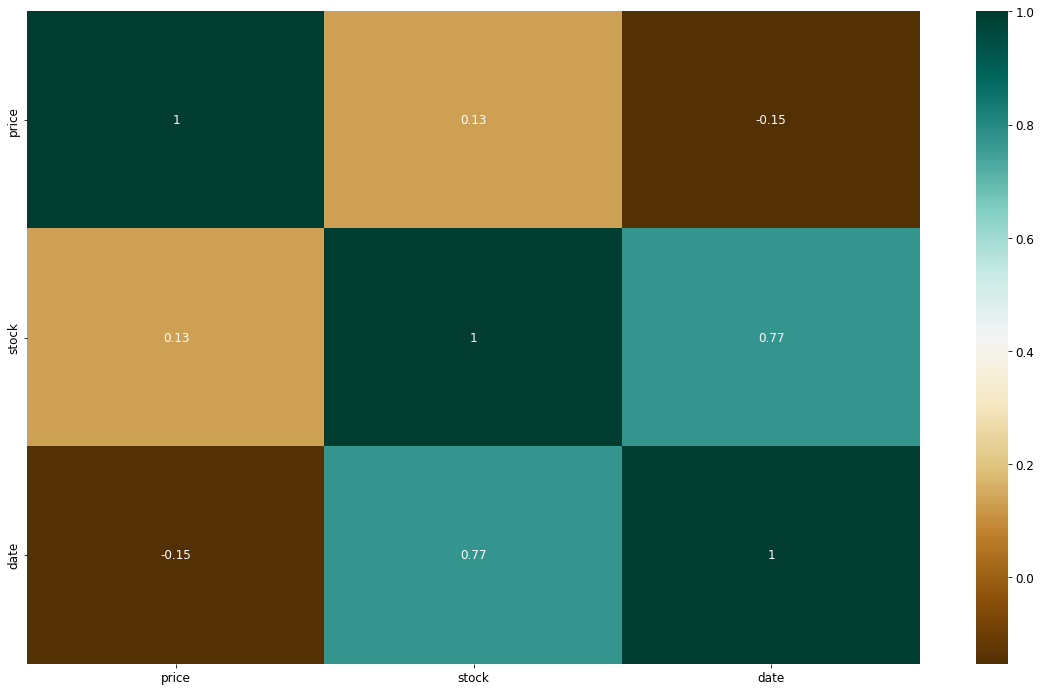

In [53]:
plt.figure(figsize=(20,12))
sns.heatmap(correlation, cmap='BrBG', annot=True)

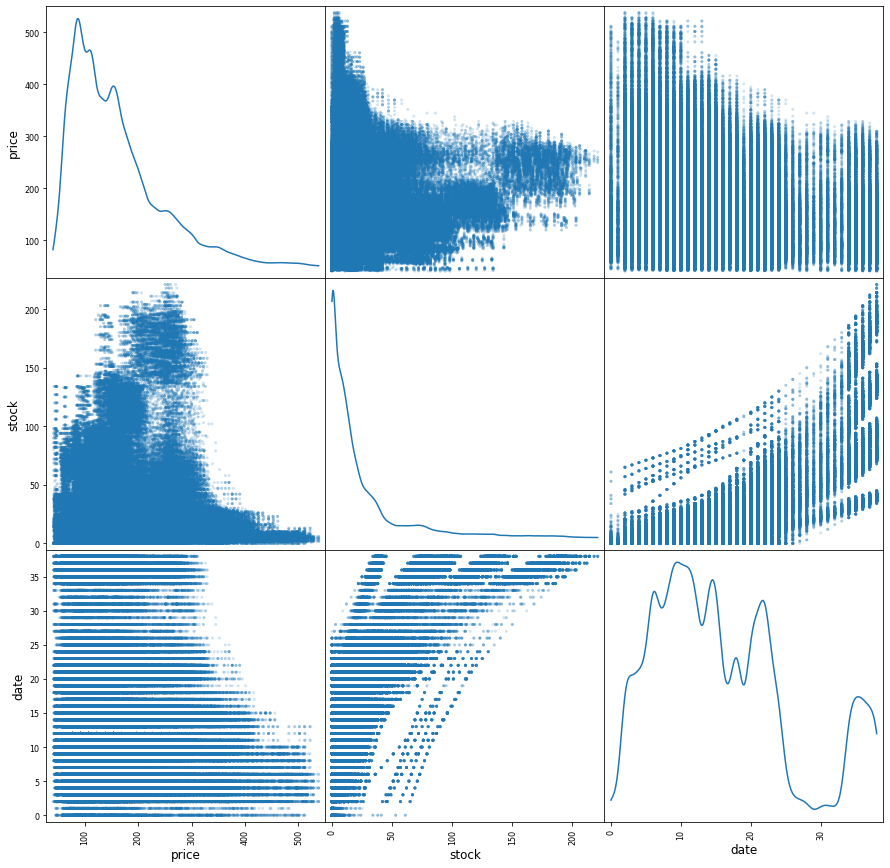

In [54]:
scatter_matrix(data[continuous_features], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

In [55]:
data.city.unique()

array(['paris', 'copenhagen', 'madrid', 'rome', 'sofia', 'vilnius',
       'vienna', 'amsterdam', 'valletta'], dtype=object)

In [56]:
pd_city = pd.DataFrame()
pd_city['city'] = data.city.unique()
pd_city['lat'] = np.array([48.87, 55.69, 40.42, 41.89, 42.70, 54.69, 48.21, 52.37,35.90])
pd_city['lon'] = np.array([2.34, 12.57, -3.70, 12.48, 23.32, 25.28, 16.37, 4.89,14.51])
pd_city['mean_price'] = np.zeros(len(data.city.unique()))

list_mean =[]
for l in pd_city.city.unique():
  list_mean.append(data[(data.city == l)].price.mean())

pd_city['mean_price'] = list_mean


display(pd_city)

,city,lat,lon,mean_price
0,paris,48.87,2.34,194.051362
1,copenhagen,55.69,12.57,200.470404
2,madrid,40.42,-3.70,143.694284
3,rome,41.89,12.48,152.192106
4,sofia,42.70,23.32,90.904144
5,vilnius,54.69,25.28,112.303411
6,vienna,48.21,16.37,158.462799
7,amsterdam,52.37,4.89,169.178666
8,valletta,35.90,14.51,147.855035


Analysis of the prices according to a city

In [57]:
import folium
 

def color(value): 
    if value <= 120.0 : 
        col = 'green'
    elif value > 120.0 and value <=160.0 : 
        col = 'orange'
    else: 
        col='red'
    return col 
      
map = folium.Map(location=[pd_city.lat.mean(),pd_city.lon.mean()], zoom_start=4) 

# Top three smart phone companies by market share in 2016
for lat,lan,value in zip(pd_city['lat'],pd_city['lon'],pd_city['mean_price']): 
    folium.Marker(location=[lat,lan],icon= folium.Icon(color=color(value),icon_color='black',icon = 'home')).add_to(map) 
map

In [59]:
Xtrain = pd.read_csv('/content/Defi_IA_2023/trainset.csv',index_col=0)
Ytrain = pd.read_csv('/content/Defi_IA_2023/labelstrain.csv',index_col=0)
Xtest = pd.read_csv('/content/Defi_IA_2023/testset.csv',index_col=0)
Ypred = pd.read_csv('/content/Defi_IA_2023/final_predictions4.csv',index_col=0)

In [60]:
# Loading des poids
import pickle
xgb_model_loaded = pickle.load(open('/content/Defi_IA_2023/model_gbmOpt_mat4.pkl', "rb"))

In [62]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 12.4 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=204bc93d2cac0869a9dce4f537ad990cfd47941bc5bc6a435555aac949150c4b
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

In [ ]:
#!pip install pdpbox

Text(0.5, 1.0, 'Gradient Boosting Regression')

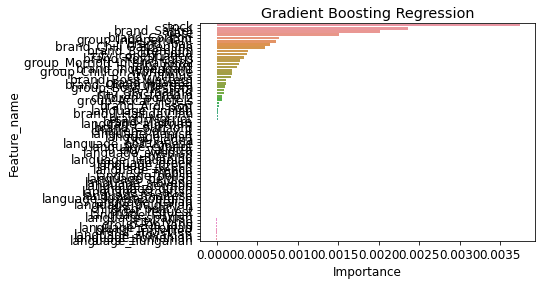

In [64]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = Xtrain.columns
model = xgb_model_loaded
model_name = 'Gradient Boosting Regression'

permumtation_import = PermutationImportance(model).fit(Xtest, Ypred)
features_importance = {'Feature_name':feature_names, 'Importance':permumtation_import.feature_importances_}  
features_importance = pd.DataFrame(features_importance) # dataframe containing the features names and their importance
features_importance = features_importance.sort_values(by="Importance", ascending = False) # sort the dataframe by feature importance
ax = sns.barplot(x='Importance', y='Feature_name', data=features_importance) #plot the model's features importance
plt.title(model_name)

Text(0.5, 1.0, 'random forest')

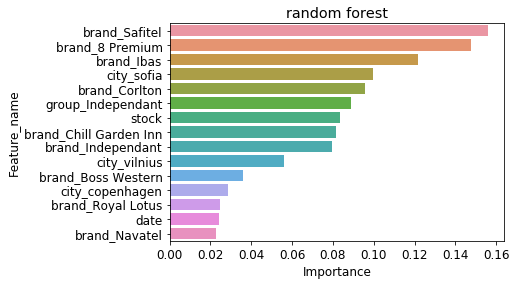

In [ ]:
ax = sns.barplot(x='Importance', y='Feature_name', data=features_importance[:15]) #plot the model's features importance
plt.title(model_name)

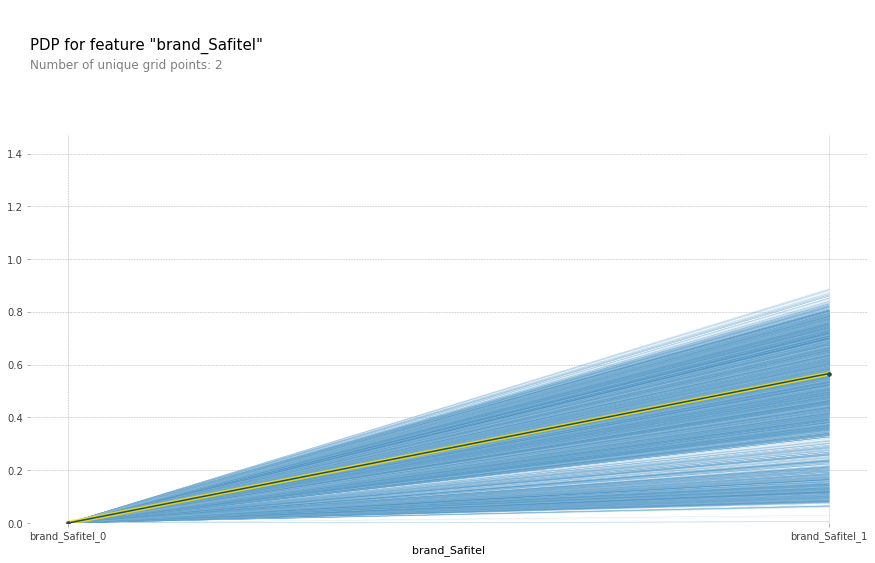

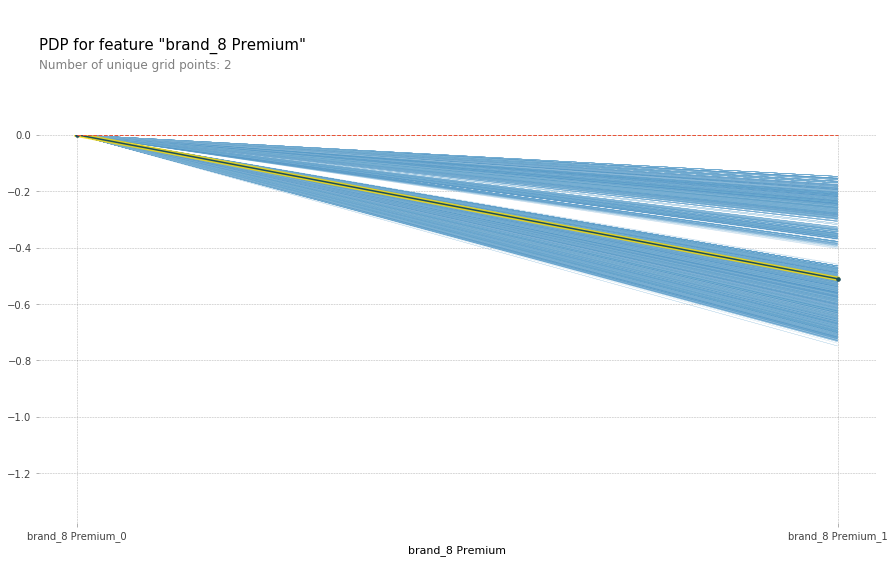

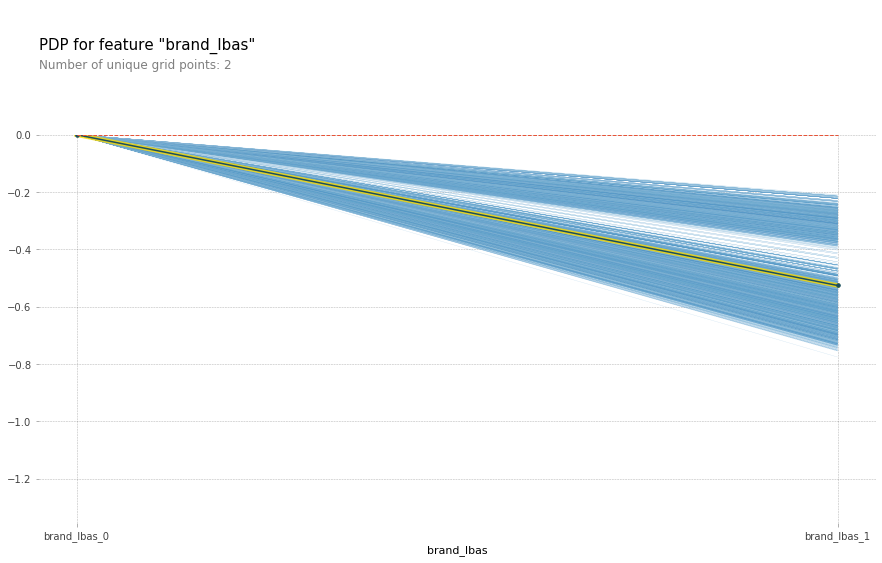

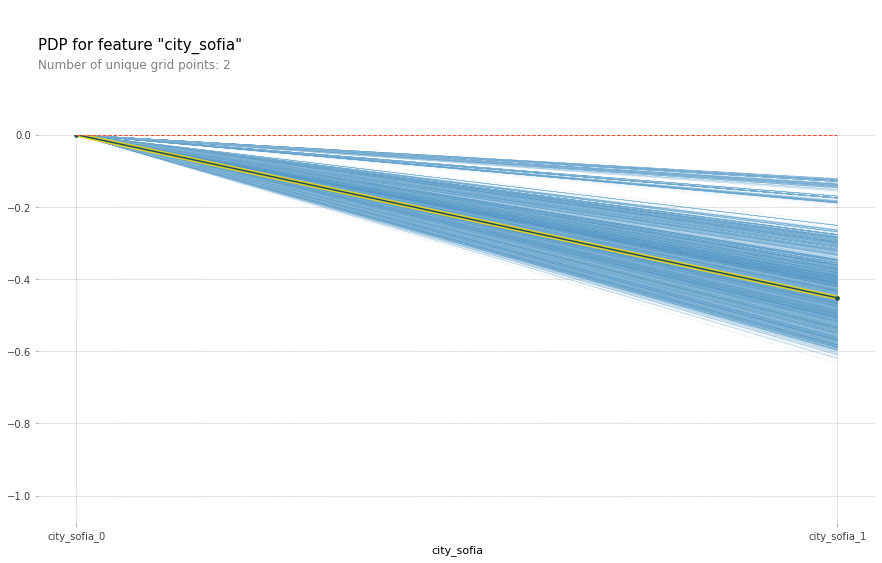

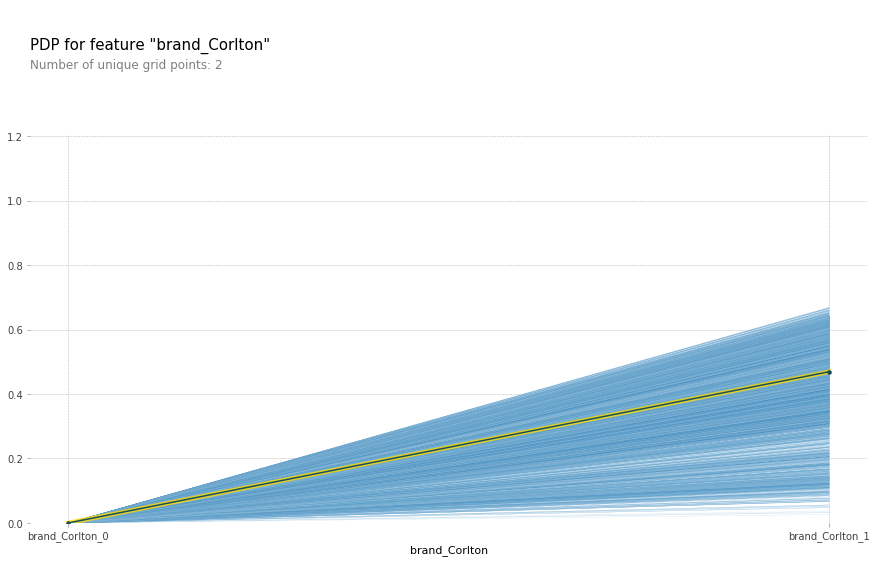

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

top_5_features = features_importance.Feature_name[:5].values
for i, feature in enumerate(top_5_features, 1):
  pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features= feature_names, feature=feature)
  pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.5)
plt.show()

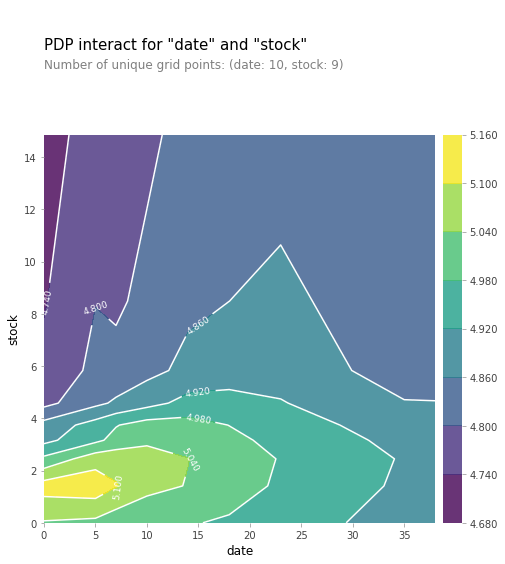

In [ ]:
features_to_plot = ['date', 'stock']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

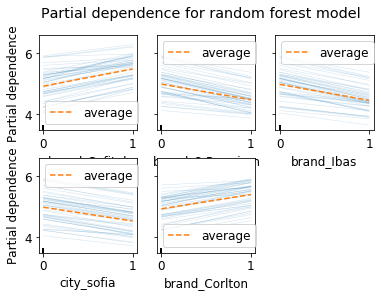

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

top_5_features = features_importance.Feature_name[:5].values
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    top_5_features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
    )
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

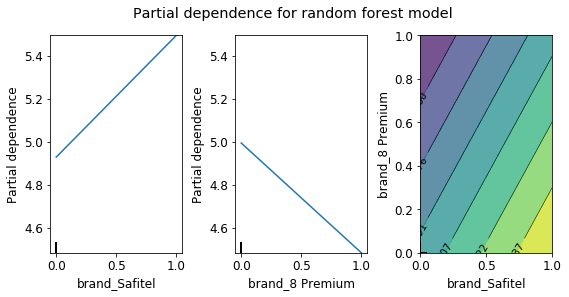

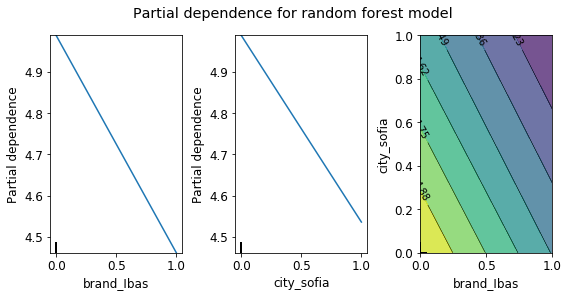

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
top_5_features = features_importance.Feature_name[:5].values
features = [top_5_features[0], top_5_features[1], (top_5_features[0], top_5_features[1])]
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

_, ax = plt.subplots(ncols=3, figsize=(9, 4))
features = [top_5_features[2], top_5_features[3], (top_5_features[2], top_5_features[3])]
display = PartialDependenceDisplay.from_estimator(
    model,
    X_test,
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

# Interpretability with Target encoding

In [81]:
def format_test(X):
  X_test = X.copy()

  hotels = pd.read_csv('/content/Defi_IA_2023/features_hotels.csv',index_col=0)
  hotels = hotels.drop(['city'], axis = 1)
  X_test = X_test.join(hotels, on = 'hotel_id')

  # order request
  X_test = X_test.assign(order_request=0)
  X_test['order_request'] = 1
  for avatar in np.unique(X_test['avatar_id']):
      X_test.loc[X_test['avatar_id'] == avatar, 'order_request'] = X_test['order_requests'].loc[X_test['avatar_id']== avatar] - min(X_test['order_requests'].loc[X_test['avatar_id']== avatar])+1
  X_test = X_test.drop(['order_requests'], axis = 1)

  return X_test

X_test = pd.read_csv('/content/Defi_IA_2023/test_set.csv',index_col=0)
data_test = format_test(X_test.copy())

In [82]:
data = pd.concat([Matrix1, Matrix2, Matrix4,Matrix5, Matrix6_part1, Matrix6_part2,Matrix8_part1, Matrix8_part2, Matrix8_part3])

In [83]:
data = data.drop(['name', 'avatar_id'], axis=1)

In [84]:
hotels = pd.read_csv('/content/Defi_IA_2023/features_hotels.csv',index_col=0)
hotels = hotels.drop(['city'], axis = 1)
data = data.join(hotels, on = 'hotel_id')


In [85]:
for i in data.columns:
  if (i!='price') and (i!='order_request') and (i!='avatar_id') and (i!='date') and (i!='stock') and (i!='hotel_id'):
    agg = data.groupby(i)['price'].agg(['mean','var',lambda x : (x.count()*x.mean()+1.96)/(x.count()+1.96*(x.max()-x.min()))])
    agg = agg.rename(columns = {'<lambda_0>':'additive_smoothing'})
    agg = agg.add_suffix('_'+i)
    data = data.join(agg,on=i)
    data.drop(i,inplace=True,axis=1)
    data_test = data_test.join(agg,on=i)
    data_test.drop(i,inplace=True,axis=1)
data_test

,date,avatar_id,hotel_id,stock,order_request,mean_city,var_city,additive_smoothing_city,mean_language,var_language,...,additive_smoothing_brand,mean_parking,var_parking,additive_smoothing_parking,mean_pool,var_pool,additive_smoothing_pool,mean_children_policy,var_children_policy,additive_smoothing_children_policy
index,,,,,,,,,,,,,,,,,,,,,
0,21,1,161,46,1,112.104585,2470.735688,111.105249,147.480012,6254.779485,...,141.239727,155.041339,6556.523290,154.341993,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867
1,21,1,187,32,1,112.104585,2470.735688,111.105249,147.480012,6254.779485,...,187.871905,155.041339,6556.523290,154.341993,238.381713,6656.212480,235.738005,148.550758,6148.659253,148.246867
2,21,1,279,12,1,112.104585,2470.735688,111.105249,147.480012,6254.779485,...,90.698198,155.041339,6556.523290,154.341993,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867
3,21,1,395,10,1,112.104585,2470.735688,111.105249,147.480012,6254.779485,...,78.494178,148.140379,6217.072017,147.633614,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867
4,21,1,488,42,1,112.104585,2470.735688,111.105249,147.480012,6254.779485,...,279.168835,155.041339,6556.523290,154.341993,238.381713,6656.212480,235.738005,181.244363,7016.246505,172.501014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,5,794,987,1,3,151.948419,5684.559242,150.029343,150.870452,6111.066444,...,78.494178,155.041339,6556.523290,154.341993,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867
6640,1,794,26,1,4,158.420936,5244.490645,155.531928,150.870452,6111.066444,...,187.871905,155.041339,6556.523290,154.341993,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867
6641,1,794,263,0,4,158.420936,5244.490645,155.531928,150.870452,6111.066444,...,118.581113,155.041339,6556.523290,154.341993,134.261061,4565.603259,133.950071,148.550758,6148.659253,148.246867


In [86]:
data.drop_duplicates(keep = 'first', inplace=True)

In [87]:
data.additive_smoothing_pool = data.additive_smoothing_pool.astype(object)
data.additive_smoothing_parking = data.additive_smoothing_parking.astype(object)
data.additive_smoothing_children_policy = data.additive_smoothing_children_policy.astype(object)
data.additive_smoothing_mobile = data.additive_smoothing_mobile.astype(object)
data.additive_smoothing_city = data.additive_smoothing_city.astype(object)
data.additive_smoothing_brand = data.additive_smoothing_brand.astype(object)
data.additive_smoothing_group = data.additive_smoothing_group.astype(object)
data.additive_smoothing_language = data.additive_smoothing_language.astype(object)
data.order_request = data.order_request.astype(object)
data.mean_city = data.mean_city.astype(object)
data.var_city = data.var_city.astype(object)
data.mean_pool = data.mean_pool.astype(object)
data.var_pool = data.var_pool.astype(object)
data.mean_parking = data.mean_parking.astype(object)
data.var_parking = data.var_parking.astype(object)
data.mean_children_policy = data.mean_children_policy.astype(object)
data.var_children_policy = data.var_children_policy.astype(object)
data.mean_mobile = data.mean_mobile.astype(object)
data.var_mobile = data.var_mobile.astype(object)
data.mean_brand = data.mean_brand.astype(object)
data.var_brand = data.var_brand.astype(object)
data.mean_group = data.mean_group.astype(object)
data.var_group = data.var_group.astype(object)
data.mean_language = data.mean_language.astype(object)
data.var_language = data.var_language.astype(object)
data.hotel_id = data.hotel_id.astype(object)

In [88]:
pd_city = pd.DataFrame()
pd_city['city'] = data.mean_city.unique()
pd_city['lat'] = np.array([48.87, 55.69, 40.42, 41.89, 42.70, 54.69, 48.21, 52.37,35.90])
pd_city['lon'] = np.array([2.34, 12.57, -3.70, 12.48, 23.32, 25.28, 16.37, 4.89,14.51])
pd_city['mean_price'] = np.zeros(len(data.mean_city.unique()))

#list_mean =[]
#for l in pd_city.city.unique():
#  list_mean.append(data[(data.city == l)].price.mean())

pd_city['mean_price'] = pd_city['city']


display(pd_city)

,city,lat,lon,mean_price
0,193.984833,48.87,2.34,193.984833
1,200.504526,55.69,12.57,200.504526
2,143.205284,40.42,-3.70,143.205284
3,151.948419,41.89,12.48,151.948419
4,90.827759,42.70,23.32,90.827759
5,112.104585,54.69,25.28,112.104585
6,158.420936,48.21,16.37,158.420936
7,169.236767,52.37,4.89,169.236767
8,147.711149,35.90,14.51,147.711149


In [89]:
import folium
 

def color(value): 
    if value <= 120.0 : 
        col = 'green'
    elif value > 120.0 and value <=160.0 : 
        col = 'orange'
    else: 
        col='red'
    return col 
      
map = folium.Map(location=[pd_city.lat.mean(),pd_city.lon.mean()], zoom_start=4) 

# Top three smart phone companies by market share in 2016
for lat,lan,value in zip(pd_city['lat'],pd_city['lon'],pd_city['mean_price']): 
    folium.Marker(location=[lat,lan],icon= folium.Icon(color=color(value),icon_color='black',icon = 'home')).add_to(map) 
map

In [90]:
Y_pred = pd.read_csv('/content/Defi_IA_2023/submission_target_boosting_04_01_2eme.csv')

In [91]:
Y_pred = Y_pred.drop(['index'],axis=1)

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from time import perf_counter

gbm = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=500))
#gbmOpt=gbm.fit(Xtrain, Ytrain)


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Gradient Boosting Regression')

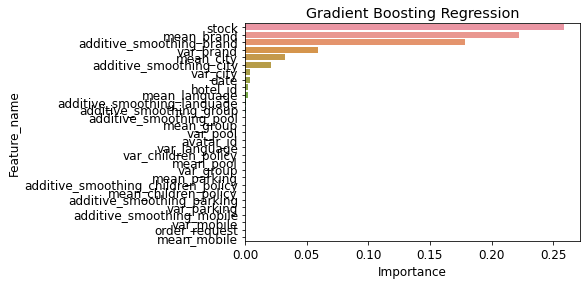

In [94]:
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = data_test.columns
model = gbm
model_name = 'Gradient Boosting Regression'
model = gbm.fit(data_test, Y_pred)
permumtation_import = PermutationImportance(model).fit(data_test, Y_pred)
features_importance = {'Feature_name':feature_names, 'Importance':permumtation_import.feature_importances_}  
features_importance = pd.DataFrame(features_importance) # dataframe containing the features names and their importance
features_importance = features_importance.sort_values(by="Importance", ascending = False) # sort the dataframe by feature importance
ax = sns.barplot(x='Importance', y='Feature_name', data=features_importance) #plot the model's features importance
plt.title(model_name)

Text(0.5, 1.0, 'Gradient Boosting Regression')

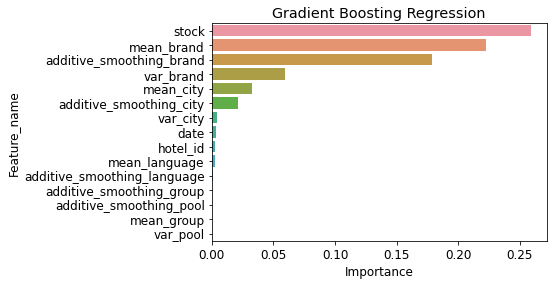

In [95]:
ax = sns.barplot(x='Importance', y='Feature_name', data=features_importance[:15]) #plot the model's features importance
plt.title(model_name)

In [97]:
pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.0/34.0 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=b2a5a98c2e913eaefc281e5d47489f1edeb48bddc290811e476927c1a3b7cd2d
  Stored in directory: /root/.cache/pip/wheels/35/fb/ef/a08dd2a1611435285fa3f9d9104bf554f10c2eb7293b526ccb
  Created wheel for matplotlib: filename=matplotlib-3.1.1-cp38-cp38-linux_x86_64.whl size=11152268 sha256=83bebb7e5da490d911f8ece74a3e94fec1eb678f7f085b3be8ec35582960dfed
  Stored in directory: /root/.cache/pip/wheels/85/86/f1/054e7477b5e68f3c4a1258d12ae1c2205d6889283ce631dfe5
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

top_5_features = features_importance.Feature_name[:5].values
for i, feature in enumerate(top_5_features, 1):
  pdp_feat = pdp.pdp_isolate(model=model, dataset=data_test, model_features= feature_names, feature=feature)
  pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.5)
plt.show()

In [ ]:
features_to_plot = ['date', 'stock']
inter1 = pdp.pdp_interact(model=model, dataset=data_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

In [ ]:
top_5_features = features_importance.Feature_name[:5].values
display = PartialDependenceDisplay.from_estimator(
    model,
    data_test,
    top_5_features,
    kind="both",
    subsample=50,
    n_jobs=3,
    n_cols=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"}
    )
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(hspace=0.3)

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
top_5_features = features_importance.Feature_name[:5].values
features = [top_5_features[0], top_5_features[1], (top_5_features[0], top_5_features[1])]
display = PartialDependenceDisplay.from_estimator(
    model,
    data_test,
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

_, ax = plt.subplots(ncols=3, figsize=(9, 4))
features = [top_5_features[2], top_5_features[3], (top_5_features[2], top_5_features[3])]
display = PartialDependenceDisplay.from_estimator(
    model,
    data_test,
    features,
    kind="average",
    n_jobs=3,
    grid_resolution=20,
    ax=ax,
)
display.figure_.suptitle(f"Partial dependence for {model_name} model")
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

In [ ]:
!pip install shap > /dev/null 2>&1

In [ ]:
import shap
shap.initjs()

In [ ]:
shap.initjs() #needed to plot results directly on the notebook

idx = 1 # index of the instance we want to explain

explainer = shap.KernelExplainer(gbm[1].predict, data_test)
shap_values = explainer.shap_values(data_test.iloc[0, :])
shap.force_plot(explainer.expected_value, shap_values, data_test.iloc[0, :])
 #Summary on the dataset. To speed up we just compute the shap values for 20 exemples

In [ ]:
shap.initjs() 
shap_values = explainer.shap_values(data_test.iloc[0:20, :])
shap.force_plot(explainer.expected_value, shap_values, data_test.iloc[0:20, :])